In [1]:
import pandas as pd
import dill
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.inspection import plot_partial_dependence, permutation_importance

%cd C:\Users\user\Desktop\KUL - Mstat\Modern Data Analytics\proj

C:\Users\user\Desktop\KUL - Mstat\Modern Data Analytics\proj


In [2]:
# import data
mortality = pd.read_csv('mortality_merged.csv')

In [3]:
class subset_helper():
    def __init__(self, data):
        self.data = data
        
    def get_summer(self, df):
        return df[(df['MONTH'] <= 8) & (df['MONTH'] >= 5)]

    def get_disease(self, df):
        diseases = ('Diseases of the circulatory system', 
                    'Diseases of the respiratory system', 
                    'Diseases of the skin and subcutaneous tissue')
        return df[df['COD'].isin(diseases)]
    
    def subset(self):
        self.data = self.get_summer(self.data)
        self.data = self.get_disease(self.data)
        return self.data
mortality = subset_helper(mortality).subset()

In [4]:
# Train-test split
TEST_SIZE = 0.1
SEED = 467051528
X_train, X_test, y_train, y_test = train_test_split(mortality.drop('COUNT', axis = 1), 
                                                    mortality['COUNT'], 
                                                    test_size = TEST_SIZE,
                                                    random_state = SEED,
                                                    shuffle = True)

In [5]:
# load model
with open('gradientboosting.pkl', 'rb') as file:
    model = dill.load(file) 

In [6]:
# Eli5 cannot handle preprocessing steps, must pass np.array
def transform_data(model, X):
    return make_pipeline(model.named_steps['preprocessing']).transform(X)

In [7]:
# Get feature names from the pipeline obj
def get_feature_names(model):
    cont_name = model.named_steps['preprocessing'].transformers_[1][2]
    cat_name = model.named_steps['preprocessing'].transformers_[2][1].get_feature_names().tolist()
    return cont_name + cat_name

In [8]:
# Permutation importance for training data
permutation = permutation_importance(model, X_train, y_train)

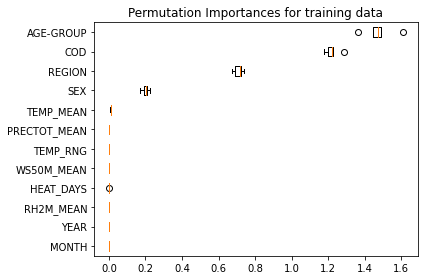

In [9]:
sorted_idx = permutation.importances_mean.argsort()
fig, ax = plt.subplots()
ax.boxplot(permutation.importances[sorted_idx].T,
           vert = False, labels = X_train.columns[sorted_idx])
ax.set_title('Permutation Importances for training data')
fig.tight_layout()
plt.show()

In [10]:
permutation.importances[sorted_idx].shape

(12, 5)

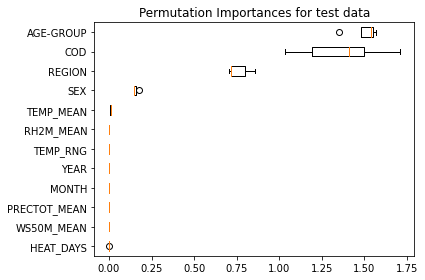

In [11]:
permutation = permutation_importance(model, X_test, y_test)
sorted_idx = permutation.importances_mean.argsort()
fig, ax = plt.subplots()
ax.boxplot(permutation.importances[sorted_idx].T,
           vert = False, labels = X_test.columns[sorted_idx])
ax.set_title('Permutation Importances for test data')
fig.tight_layout()
plt.show()